This notebook reproduces the analyses shown in the paper "Lipid shape and packing are key for optimal design of pH-sensitive mRNA lipid nanoparticles" 

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from jinja2 import Template
import pandas as pd
from pathlib import Path
from io import StringIO 
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

In [2]:
!mkdir figs

Bead sizes of the CG lipid models

In [3]:
df_m = pd.DataFrame()

hd_range = np.arange(1.8,2.51,.05)
t1_range = np.arange(3,4,.05)
t2_range = np.arange(4.1,4.36,.05)

cnt = 0
for hd in hd_range:
    for t1 in t1_range:
        for t2 in t2_range:
            rmax = 2.5*(hd+t2)+3*t1
            l = hd+2*t1+t2
            a = np.pi*hd**2
            v = 1/3 * np.pi * l * (hd**2 + hd * t2 + t2**2)
            cpp = v/l/a
            volume = 4/3*np.pi*(hd**3+t1**3+t2**3)
            df_m.loc[cnt,'volume'] = volume
            df_m.loc[cnt,'v'] = v
            df_m.loc[cnt,'l'] = round(l,1)
            df_m.loc[cnt,'HD'] = hd
            df_m.loc[cnt,'T1'] = t1
            df_m.loc[cnt,'T2'] = t2
            df_m.loc[cnt,'CPP'] = round(cpp,2)
            cnt += 1
            
models = df_m.query('abs(l-13.2)<0.1 and abs(volume-540)<10 and CPP > 1 and CPP <4'
          ).sort_values('CPP')[
    ['HD','T1','T2','CPP']].set_index('CPP').T

models = models[[1.86,2.03,2.06,2.22,2.26,2.54,2.80,2.93,3.03,3.09]]
models = models.loc[:,~models.columns.duplicated()]
','.join([f'{m:g}' for m in models.columns])

'1.86,2.03,2.06,2.22,2.26,2.54,2.8,2.93,3.03,3.09'

Molecular volumes

In [4]:
(4/3*np.pi*models**3).sum()

CPP
1.86    530.798259
2.03    546.490514
2.06    537.932292
2.22    543.036857
2.26    535.119519
2.54    545.514526
2.80    533.775965
2.93    530.200309
3.03    544.868929
3.09    548.814769
dtype: float64

Lipid bead densities

In [5]:
round((642/(4/3*np.pi*models**3).sum()).mean(),2),round((642/(4/3*np.pi*models**3).sum()).std(),2)

(1.19, 0.02)

In [6]:
round((616/(4/3*np.pi*models**3).sum()).mean(),2),round((616/(4/3*np.pi*models**3).sum()).std(),2)

(1.14, 0.01)

### Load the simulation data and save it to pickle files

In [7]:
nskip = 50 # skip the first 50 frames for equilibration
maxrows = 4000
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
obs = ['S/nm2','b/nm','d/nm','alpha','[Cl]/M','[Na]/M','lipids','phi','PP',
       'nu/nm3','Lz/nm','N/P','l_P/nm','r_P/nm','r_P-HD/nm','r_Cl/nm','cos_theta']

In [27]:
def make_table(models,path,model,pKa,nskip,pHs,max_rows=4000):
    index = pd.MultiIndex(levels=[obs,['AVG', 'SD']],
                  codes=[np.repeat(range(len(obs)),2),[0, 1]*len(obs)])
    table = pd.DataFrame(index=index,columns=pHs).T
    for pH in table.index:
        aL = 3e-3/(1+10**(pKa-pH))
        current_path = path.format(model,pKa,pH,aL)
        cos_theta = np.loadtxt(current_path+'/order.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        c = np.loadtxt(current_path+'/NHHD.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        z = np.loadtxt(current_path+'/Nlipids.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        table.loc[pH]['alpha','AVG'] = (c/z).mean()
        table.loc[pH]['alpha','SD'] = (c/z).std()
        table.loc[pH]['cos_theta','AVG'] = (cos_theta).mean()
        table.loc[pH]['cos_theta','SD'] = (cos_theta).std()
        table.loc[pH]['lipids','AVG'] = z.mean()
        table.loc[pH]['lipids','SD'] = z.std()
        
        y = np.loadtxt(current_path+'/Rcyl.dat',usecols=1,skiprows=nskip,max_rows=max_rows)[:1000]     
        diff = models[model]['HD']/2
        b = y.mean()
        b_error = y.std()
        
        table.loc[pH]['b/nm','AVG'] = b/10 
        table.loc[pH]['b/nm','SD'] = b_error/10
        l = np.loadtxt(path.format(model,pKa,pH,aL)+'/Lz.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        s = 2*np.pi*b*l/z#/(np.pi*models[model]['HD']**2)
        table.loc[pH]['Lz/nm','AVG'] = l.mean()/10
        table.loc[pH]['Lz/nm','SD'] = l.std()/10
        table.loc[pH]['S/nm2','AVG'] = s.mean()/100
        s_error = s.mean()*np.sqrt((b_error/b)**2+(l.std()/l.mean())**2+(z.std()/z.mean())**2)/100 
        table.loc[pH]['S/nm2','SD'] = s_error
        d = np.loadtxt(current_path+'/radius.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        table.loc[pH]['d/nm','AVG'] = (d*2).mean()/10 
        table.loc[pH]['d/nm','SD'] = (d*2).std()/10 
        V = 2*np.sqrt(3)*d*d*l
        phi = 2*np.pi*b*b/(4*d*d*np.sqrt(3))
        nu = s*d*(1-phi)/np.sqrt(phi*2*np.pi/np.sqrt(3))
        pp = (1-phi)/(np.sqrt(phi*2*np.pi/np.sqrt(3))-2*phi)
        table.loc[pH]['phi','AVG'] = phi.mean()
        table.loc[pH]['phi','SD'] = phi.std()
        table.loc[pH]['PP','AVG'] = pp.mean()
        table.loc[pH]['PP','SD'] = pp.std()
        table.loc[pH]['nu/nm3','AVG'] = nu.mean()/1e3
        table.loc[pH]['nu/nm3','SD'] = nu.std()/1e3
        if os.path.isfile(current_path+'/RMP.dat'):
            p = np.loadtxt(current_path+'/RMP.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
            rp = p.mean()
            rp_error = p.std()
            table.loc[pH]['r_P-HD/nm','AVG'] = (b-rp)/10
            table.loc[pH]['r_P-HD/nm','SD'] = (b_error+rp_error)/10
            table.loc[pH]['r_P/nm','AVG'] = rp/10
            table.loc[pH]['r_P/nm','SD'] = rp_error/10
            table.loc[pH]['N/P','AVG'] = (z/72).mean()
            table.loc[pH]['N/P','SD'] = (z/72).std()
            table.loc[pH]['l_P/nm','AVG'] = l.mean()/72/10
            table.loc[pH]['l_P/nm','SD'] = l.std()/72/10 
        n = np.loadtxt(current_path+'/NCl.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        conc = n/V/phi/6.022*1e4
        table.loc[pH]['[Cl]/M','AVG'] = conc.mean()
        table.loc[pH]['[Cl]/M','SD'] = conc.std()
        n = np.loadtxt(current_path+'/NNa.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        conc = n/V/phi/6.022*1e4
        table.loc[pH]['[Na]/M','AVG'] = conc.mean()
        table.loc[pH]['[Na]/M','SD'] = conc.std()
    return table

In [9]:
#writer = pd.to_excel('data_cg_models_rna.xlsx', engine='xlsxwriter')
path = 'data/lnp_w_rna_310/CPP{:.2f}_{:.2f}_{:.1f}'
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
for model,pKa in zip([1.86,2.03,2.06]+list(models.columns),[8.46]*3+[9.41]*models.columns.size):
    table = make_table(models,path,model,pKa,nskip,pHs)
    table.to_pickle('{:.2f}_{:.2f}_rna.pkl'.format(model,pKa))
    #table.to_excel(writer, 
    #        sheet_name=model+' '+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [10]:
#writer = pd.to_excel('data_cg_models_rna.xlsx', engine='xlsxwriter')
path = 'data/lnp_w_rna_310_74/CPP{:.2f}_{:.2f}_{:.1f}'
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
for model,pKa in zip([1.86,2.54,3.09],[9.41]*models.columns.size):
    table = make_table(models,path,model,pKa,nskip,pHs)
    table.to_pickle('{:.2f}_{:.2f}_rna_74.pkl'.format(model,pKa))
    #table.to_excel(writer, 
    #        sheet_name=model+' '+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [11]:
#writer = pd.ExcelWriter('data_cg_models_empty.xlsx', engine='xlsxwriter')
path = 'data/lnp_empty_310/CPP{:.2f}_{:.2f}_{:.1f}'
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
for model,pKa in zip([1.86,3.09],[8.46]+[9.41]*models.columns.size):
    table = make_table(models,path,model,pKa,nskip,pHs)
    table.to_pickle('{:.2f}_{:.2f}_empty.pkl'.format(model,pKa))
    #table.to_excel(writer, 
    #        sheet_name=model+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [28]:
#writer = pd.ExcelWriter('data_cg_models_empty.xlsx', engine='xlsxwriter')
path = 'data/lnp_empty_298/CPP{:.2f}_{:.2f}_{:.1f}'
pHs = [3.0]
for model,pKa in zip([1.86,3.09],[8.46]+[9.41]*models.columns.size):
    table = make_table(models,path,model,pKa,nskip,pHs)
    table.to_pickle('{:.2f}_{:.2f}_empty_298.pkl'.format(model,pKa))
    #table.to_excel(writer, 
    #        sheet_name=model+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [29]:
dd_empty = pd.read_pickle('1.86_8.46_empty_298.pkl')
dd_empty.loc[3,['d/nm','phi','b/nm','S/nm2']]

d/nm   AVG    7.258621
       SD     0.163628
phi    AVG    0.279711
       SD     0.012689
b/nm   AVG    2.014032
       SD     0.044302
S/nm2  AVG    0.404017
       SD     0.020369
Name: 3.0, dtype: object

In [30]:
mc3_empty = pd.read_pickle('3.09_9.41_empty_298.pkl')
mc3_empty.loc[3,['d/nm','phi','b/nm','S/nm2']]

d/nm   AVG    6.182072
       SD     0.070452
phi    AVG    0.254557
       SD     0.005785
b/nm   AVG    1.637317
       SD     0.040901
S/nm2  AVG    0.450236
       SD     0.015204
Name: 3.0, dtype: object

### Fig. 1

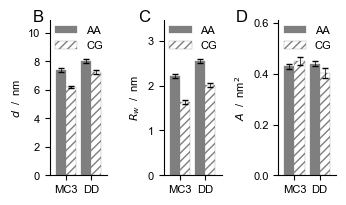

In [32]:
A = {('value','MC3'):[0.43,mc3_empty.loc[3,'S/nm2'].AVG],
     ('value','DD'):[0.44,dd_empty.loc[3,'S/nm2'].AVG],
     ('error','MC3'):[0.01,mc3_empty.loc[3,'S/nm2'].SD],
     ('error','DD'):[0.01,dd_empty.loc[3,'S/nm2'].SD]}
df_A = pd.DataFrame(A,index=['AA','CG'])
d = {('value','MC3'):[7.39,mc3_empty.loc[3,'d/nm'].AVG],
     ('value','DD'):[8.02,dd_empty.loc[3,'d/nm'].AVG],
     ('error','MC3'):[0.13,mc3_empty.loc[3,'d/nm'].SD],
     ('error','DD'):[0.15,dd_empty.loc[3,'d/nm'].SD]}
df_d = pd.DataFrame(d,index=['AA','CG'])
Rw = {('value','MC3'):[2.22,mc3_empty.loc[3,'b/nm'].AVG],
      ('value','DD'):[2.55,dd_empty.loc[3,'b/nm'].AVG],
     ('error','MC3'):[0.04,mc3_empty.loc[3,'b/nm'].SD],
      ('error','DD'):[0.05,dd_empty.loc[3,'b/nm'].SD]}
df_Rw = pd.DataFrame(Rw,index=['AA','CG'])

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(3.5,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

labels = ['$d$  /  nm','$R_w$  /  nm','$A$  /  nm$^2$']

for ax,df,l in zip([ax1,ax2,ax3],[df_d,df_Rw,df_A],labels):
    df.value.T.plot.bar(ax=ax,hatch='////',color=['tab:grey','w'],lw=.2,width=.8,edgecolor='tab:grey',
                       yerr=df.error.T,error_kw=dict(ecolor='k',elinewidth=0.5,capsize=2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x',rotation=0)
    ax.set_ylabel(l)
    ax.legend(frameon=False,loc='upper left',borderpad=0)
    ax.set_ylim(0,df.value.values.max()*1.36)
    
fig.text(0.1, .927, 'B', fontsize=12)
fig.text(0.4, .927, 'C', fontsize=12)
fig.text(0.68, .927, 'D', fontsize=12)
plt.tight_layout()
plt.savefig('figs/fig1.pdf')
plt.show()

### Fig. 2

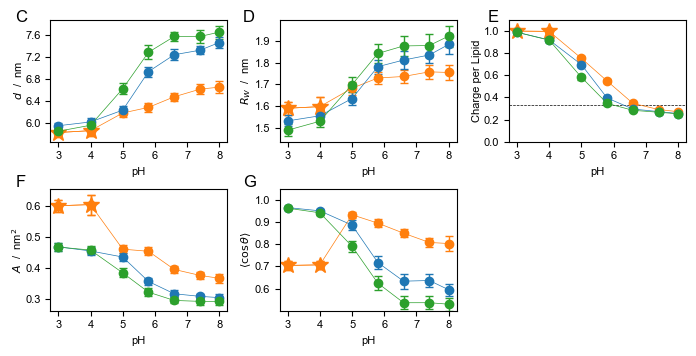

In [17]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(7,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
colors = ['tab:orange','tab:blue','tab:green']
for model,pKa,c in zip([1.86,2.54,3.09],[9.41,9.41,9.41],colors):
    table = pd.read_pickle('{:.2f}_{:.2f}_rna.pkl'.format(model,pKa))
    for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','cos_theta']):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=1, capsize=3, capthick=1, color=c)
        
    if table.loc[3.0,'cos_theta'].AVG<.8:
        for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','cos_theta']):
            ax.errorbar(table.index[:2],table[o].AVG.values[:2],table[o].SD.values[:2],
                lw=0.5, marker='*', ms=12, 
                elinewidth=1, capsize=3, capthick=1, color=c)
        
axes.flatten()[0].set_ylabel(r'$d$  /  nm',labelpad=1)
axes.flatten()[1].set_ylabel(r'$R_W$  /  nm',labelpad=1)
axes.flatten()[2].set_ylabel(r'Charge per Lipid',labelpad=1)
axes.flatten()[3].set_ylabel(r'$A$  /  nm$^2$',labelpad=1)
axes.flatten()[4].set_ylabel(r'$\langle \cos{\theta} \rangle$',labelpad=1)
for ax in axes.flatten():
    ax.set_xlabel('pH')
    ax.set_xticks(range(3,9,1))
axes.flatten()[0].set_yticks(np.arange(6,7.8,0.4))
axes.flatten()[1].set_yticks(np.arange(1.5,2.,0.1))
axes.flatten()[2].set_yticks([0,.2,.4,.6,.8,1])
axes.flatten()[4].set_yticks(np.arange(.6,1.1,0.1))
axes.flatten()[2].set_ylim(0,1.1)
axes.flatten()[4].set_ylim(.5,1.05)
axes.flatten()[5].set_axis_off()
axes.flatten()[2].axhline(1/3,ls='--',color='k',lw=.5,zorder=0)
fig.text(0.025, .96, 'C', fontsize=12)
fig.text(0.35, .96, 'D', fontsize=12)
fig.text(0.7, .96, 'E', fontsize=12)
fig.text(0.025, .49, 'F', fontsize=12)
fig.text(0.35, .49, 'G', fontsize=12)
plt.tight_layout()
plt.savefig('figs/fig2.pdf')

### Fig. 3

In [ ]:
models_snapshots = [3.09,2.54,1.86,1.86][:]

pH_values = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0][:3]

def writePQRAtom(line,ofh):
    spl = line.split()
    aname=spl[2]
    if not aname[0].isdigit():
        #print "change aname\"%s\""%aname
        aname = " "+aname
        #print "to \"%s\""%aname
    if len(spl)==11:
        outline="ATOM  %5d %-4s%1s%3s %1s%4d%1s   %8.3f%8.3f%8.3f%6.2f%6.2f      %4s%2s%2s%s\n" % (
            int(spl[1]),aname," ",spl[3],spl[4],int(spl[5])," ",float(spl[6]),float(spl[7]),
            float(spl[8]),float(spl[9]),float(spl[10]),"    ","  ","  ","")
    elif len(spl)==10:
        outline="ATOM  %5d %-4s%1s%3s %1s%4d%1s   %8.3f%8.3f%8.3f%6.2f%6.2f      %4s%2s%2s%s\n" % (
            int(spl[1]),aname," ",spl[3]," ",int(spl[4])," ",float(spl[5]),float(spl[6]),
            float(spl[7]),float(spl[8]),float(spl[9]),"    ","  ","  ","")
    else:
        raise ValueError("The format of this pqr is not as expected")
    ofh.write(outline)
    
def hex_to_vmd(color):
    h = mpl.colors.to_hex(color).lstrip('#')
    rgb = np.array([ int(h[i:i+2], 16) for i in (0, 2 ,4)])
    return ' '.join(['{:1.2f}'.format(i/255.) for i in rgb])

for folder in ['lnp_w_rna_310','lnp_empty_310']:
    path = f'data/{folder:s}'+'/CPP{:.2f}_{:.2f}_{:.1f}'
    for model,pKa in zip(models_snapshots,[9.41,9.41,9.41,8.46]):
        l = []
        for pH in pH_values:
            current_path = path.format(model,pKa,pH)
            ifname = current_path+'/cuboid_1000000.pqr'
            ofname = current_path+'/cuboid_1000000.pdb'
            with  open(ifname,"r") as ifhandle:
                with open(ofname,"w") as ofhandle:
                    for line in ifhandle:
                        if line.startswith("ATOM"):
                            writePQRAtom(line,ofhandle)
                        else:
                            ofhandle.write(line)
            s = md.load_pdb(ofname)
            index_1 = s.top.select('name T1')
            index_2 = s.top.select('name T2')
            d = md.compute_distances(s,np.c_[index_1,index_2])
            l.append(d[d<3].mean())

colors = ['tab:green','tab:blue','tab:orange','tab:red']
vmd_path = 'csh /Applications/VMD_1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh'

for folder in ['lnp_w_rna_310','lnp_empty_310']:
    path = f'data/{folder:s}'+'/CPP{:.2f}_{:.2f}_{:.1f}'
    script_path = f'../snapshot.vmd'
    for pH in pH_values:
        for model,pKa,color in zip(models_snapshots,[9.41,9.41,9.41,8.46],colors):
            current_path = path.format(model,pKa,pH)
            %cd {current_path}
            # Read in the file
            with open(script_path, 'r') as file :
                filedata = file.read()
            filedata = filedata.replace('new_box_color', hex_to_vmd(color))
            if folder == 'lnp_empty_310':
                half_box_length_y = md.load('confout.gro').unitcell_lengths[0][0]*np.sqrt(3)*10/2
                filedata = filedata.replace('half_box_length_y', f'{half_box_length_y:f}')
            with open('snapshot.vmd', 'w') as file:
                file.write(filedata)
            print(f'../{current_path.split("/")[-1]:s}.tga')
            !{vmd_path} -e snapshot.vmd -dispdev text
            !cp snapshot.tga ../{current_path.split('/')[-1]}.tga
            %cd -

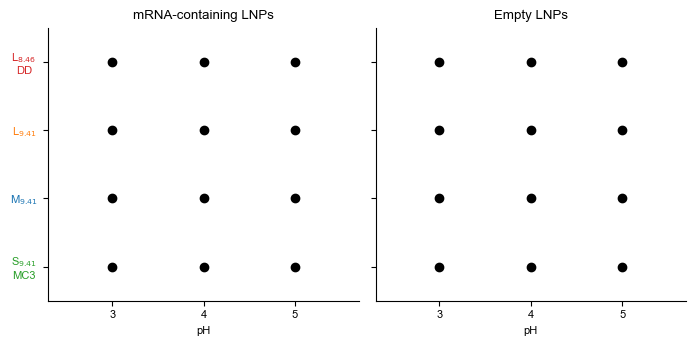

In [25]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

ax1.set_title('mRNA-containing LNPs')
ax2.set_title('Empty LNPs')

pHs = [3.0, 4.0, 5.0]
for ax in [ax1,ax2]:
    for i in range(1,5):
        ax.plot(pHs,[i]*len(pHs),marker='o',color='k',lw=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('pH')
    ax.set_ylim(.5,4.5)
    ax.set_xlim(2.3,5.7)
    ax.set_xticks(pHs)
    ax.set_yticks(range(1,5))
    ax.set_yticklabels(['S$_{9.41}$\nMC3','M$_{9.41}$','L$_{9.41}$','L$_{8.46}$\nDD'],ha='center')
    ax.tick_params(axis='y', which='major', pad=14)
    
colors = ['tab:green','tab:blue','tab:orange','tab:red']
for color,ticklabel in zip(colors,ax1.get_yticklabels()):
    ticklabel.set_color(color)
plt.tight_layout()
plt.savefig('figs/fig3.pdf')

### Fig. 4

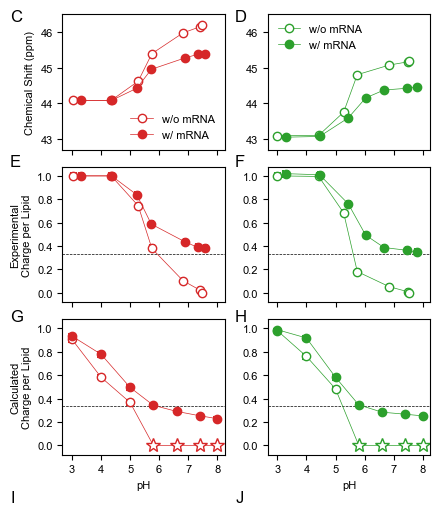

In [18]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, sharex=True, sharey=False, 
                                          figsize=(4.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

dd_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_empty')
ax1.plot(dd_empty.pH,dd_empty['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, mfc='w', color='tab:red',
            label='w/o mRNA')
dd_mRNA = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_mRNA')
ax1.plot(dd_mRNA.pH,dd_mRNA['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, color='tab:red',
            label='w/ mRNA')
      
mc3_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_empty')
ax2.errorbar(mc3_empty.pH,mc3_empty['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green',
            label='w/o mRNA')
mc3_mRNA = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_mRNA')
ax2.errorbar(mc3_mRNA.pH,mc3_mRNA['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green',
            label='w/ mRNA')
      
dd_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_empty')
ax3.errorbar(dd_empty.pH,dd_empty['alpha'], 
            xerr=dd_empty['Error pH'],yerr=dd_empty['Error alpha'],
            lw=0.5, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
dd_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_mRNA')
ax3.errorbar(dd_empty.pH,dd_empty['alpha'], 
            xerr=dd_empty['Error pH'],yerr=dd_empty['Error alpha'],
            lw=0.5, marker='o', ms=6,
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
      
mc3_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_empty')
ax4.errorbar(mc3_empty.pH,mc3_empty['alpha'],
            xerr=mc3_empty['Error pH'],yerr=mc3_empty['Error alpha'],
            lw=0.5, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green')
mc3_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_mRNA')
ax4.errorbar(mc3_empty.pH,mc3_empty['alpha'],
            xerr=mc3_empty['Error pH'],yerr=mc3_empty['Error alpha'],
            lw=0.5, marker='o', ms=6,
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green')

dd_empty = pd.read_pickle('1.86_8.46_empty.pkl')
ax5.errorbar(dd_empty.index,dd_empty['alpha'].AVG, 
            yerr=dd_empty['alpha'].SD,
            lw=0.5, color='tab:red')

ax5.errorbar(dd_empty.index[:3],dd_empty['alpha'].AVG.values[:3], 
            yerr=dd_empty['alpha'].SD.values[:3],
            lw=0, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
ax5.errorbar(dd_empty.index[3:],dd_empty['alpha'].AVG.values[3:], 
            yerr=dd_empty['alpha'].SD.values[3:],
            lw=0, marker='*', ms=10, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
dd_mRNA = pd.read_pickle('1.86_8.46_rna.pkl')
ax5.errorbar(dd_mRNA.index,dd_mRNA['alpha'].AVG, 
            yerr=dd_mRNA['alpha'].SD,
            lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')

mc3_empty = pd.read_pickle('3.09_9.41_empty.pkl')
ax6.errorbar(mc3_empty.index,mc3_empty['alpha'].AVG, 
            yerr=mc3_empty['alpha'].SD,
            lw=0.5, color='tab:green')
ax6.errorbar(mc3_empty.index[:3],mc3_empty['alpha'].AVG.values[:3], 
            yerr=mc3_empty['alpha'].SD.values[:3],
            lw=0, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green')
ax6.errorbar(mc3_empty.index[3:],mc3_empty['alpha'].AVG.values[3:], 
            yerr=mc3_empty['alpha'].SD.values[3:],
            lw=0, marker='*', ms=10, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green')
mc3_mRNA = pd.read_pickle('3.09_9.41_rna.pkl')
ax6.errorbar(mc3_mRNA.index,mc3_mRNA['alpha'].AVG, 
            yerr=mc3_mRNA['alpha'].SD,
            lw=0.5, marker='o', ms=6,
            elinewidth=2, capsize=3, capthick=1.5, color='tab:green')

ax1.legend(frameon=False,loc='lower right')
ax2.legend(frameon=False,loc='upper left')

ax5.set_xlabel('pH')
ax6.set_xlabel('pH')
ax1.set_ylabel('Chemical Shift (ppm)')
ax3.set_ylabel('Experimental\nCharge per Lipid')
ax5.set_ylabel('Calculated\nCharge per Lipid')
ax1.set_ylim(42.7,46.5)
ax2.set_ylim(42.7,46.5)
ax5.set_xticks([3,4,5,6,7,8])

for ax in [ax3,ax4,ax5,ax6]:
    ax.axhline(1/3,ls='--',color='k',lw=.5,zorder=0)
    ax.set_ylim(-.08,1.08)

fig.text(0.04, .962, 'C', fontsize=12)
fig.text(0.54, .962, 'D', fontsize=12)
fig.text(0.04, .672, 'E', fontsize=12)
fig.text(0.54, .672, 'F', fontsize=12)
fig.text(0.04, .362, 'G', fontsize=12)
fig.text(0.54, .362, 'H', fontsize=12)
fig.text(0.04, 0, 'I', fontsize=12)
fig.text(0.54, 0, 'J', fontsize=12)

fig.tight_layout()
plt.savefig('figs/fig4.pdf')

### Fig. 5

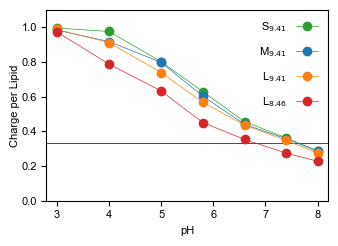

In [27]:
fig = plt.figure(figsize=(3.42,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
pb_data = pd.read_csv('data/PB_data.txt',delimiter=r'\s+')
colors = ['tab:green','tab:blue','tab:orange','tab:red']
labels = ['S$_{9.41}$','M$_{9.41}$','L$_{9.41}$','L$_{8.46}$']
for model,c,l in zip(pb_data.columns,colors,labels):
    plt.plot(pb_data.index, pb_data[model], lw=0.5, marker='o', ms=6, color=c, 
             label=l)
plt.hlines(1/3,2.8,8.2,ls='-',color='k',lw=.5,zorder=0)

        
plt.ylabel(r'Charge per Lipid',labelpad=1)
plt.xlabel('pH')
plt.legend(markerfirst=False,frameon=False,labelspacing=1,loc='upper right')
plt.ylim(0,1.1)
plt.xlim(2.8,8.2)
plt.tight_layout()
plt.savefig('figs/fig5.pdf',dpi=300)

### Fig. S4

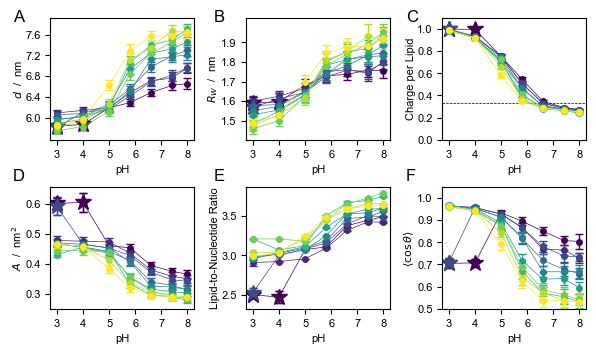

In [33]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(6,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
viridis = mpl.colormaps.get_cmap('viridis')
colors = viridis(np.linspace(0,1,models.columns.size))
for model,pKa,c in zip(models.columns,[9.41]*models.columns.size,colors):
    table = pd.read_pickle('{:.2f}_{:.2f}_rna.pkl'.format(model,pKa))
        
    for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','N/P','cos_theta']):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=4, 
            elinewidth=1, capsize=3, capthick=1, color=c)    
        if table.loc[3.0,'cos_theta'].AVG<.85:
            ax.errorbar(table.index[:1],table[o].AVG.values[:1],table[o].SD.values[:1],
                lw=0.5, marker='*', ms=12, 
                elinewidth=1, capsize=3, capthick=1, color=c)
        if table.loc[4.0,'cos_theta'].AVG<.85:
            ax.errorbar(table.index[1:2],table[o].AVG.values[1:2],table[o].SD.values[1:2],
                lw=0.5, marker='*', ms=12, 
                elinewidth=1, capsize=3, capthick=1, color=c)
        
axes.flatten()[0].set_ylabel(r'$d$  /  nm',labelpad=1)
axes.flatten()[1].set_ylabel(r'$R_W$  /  nm',labelpad=1)
axes.flatten()[2].set_ylabel(r'Charge per Lipid',labelpad=1)
axes.flatten()[3].set_ylabel(r'$A$  /  nm$^2$',labelpad=1)
axes.flatten()[4].set_ylabel(r'Lipid-to-Nucleotide Ratio',labelpad=1)
axes.flatten()[5].set_ylabel(r'$\langle \cos{\theta} \rangle$',labelpad=1)
for ax in axes.flatten():
    ax.set_xlabel('pH')
    ax.set_xticks(range(3,9,1))
axes.flatten()[0].set_yticks(np.arange(6,7.8,0.4))
axes.flatten()[1].set_yticks(np.arange(1.5,2.,0.1))
axes.flatten()[2].set_yticks([0,.2,.4,.6,.8,1])
axes.flatten()[5].set_yticks(np.arange(.5,1.05,0.1))
axes.flatten()[2].set_ylim(0,1.1)
axes.flatten()[5].set_ylim(.5,1.05)
axes.flatten()[2].axhline(1/3,ls='--',color='k',lw=.5,zorder=0)
fig.text(0.025, .955, 'A', fontsize=12)
fig.text(0.36, .955, 'B', fontsize=12)
fig.text(0.68, .955, 'C', fontsize=12)
fig.text(0.025, .5, 'D', fontsize=12)
fig.text(0.36, .5, 'E', fontsize=12)
fig.text(0.68, .5, 'F', fontsize=12)
plt.tight_layout()
plt.savefig('figs/figS4.pdf',dpi=300)

### Fig. S5

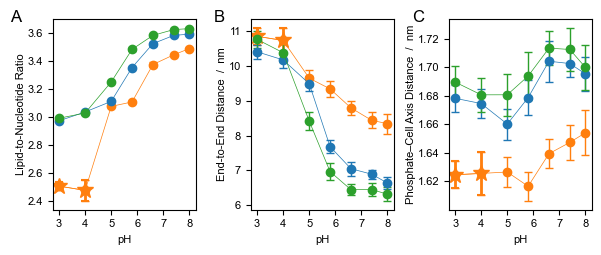

In [34]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(6,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
colors = ['tab:orange','tab:blue','tab:green']
for model,pKa,c in zip([1.86,2.54,3.09],[9.41,9.41,9.41],colors):
    table = pd.read_pickle('{:.2f}_{:.2f}_rna.pkl'.format(model,pKa))
    for o,ax in zip(['N/P','Lz/nm','PP','r_P/nm'],axes):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=1, capsize=3, capthick=1, color=c)

        if model == 1.86:
            ax.errorbar(table.index[:2],table[o].AVG.values[:2],table[o].SD.values[:2],
                lw=0.5, marker='*', ms=12, 
                elinewidth=2, capsize=3, capthick=1.5, color=c)
  
        ax.set_xlabel('pH')
        ax.set_xticks(range(3,9,1))
        
axes[0].set_ylabel(r'Lipid-to-Nucleotide Ratio',labelpad=1)
axes[1].set_ylabel(r'End-to-End Distance  /  nm',labelpad=1)
axes[2].set_ylabel(r'Phosphate–Cell Axis Distance  /  nm',labelpad=1)

fig.text(0.01, .94, 'A', fontsize=12)
fig.text(0.35, .94, 'B', fontsize=12)
fig.text(0.68, .94, 'C', fontsize=12)
plt.tight_layout()
plt.savefig('figs/figS5.pdf',dpi=300)

### Fig. S6

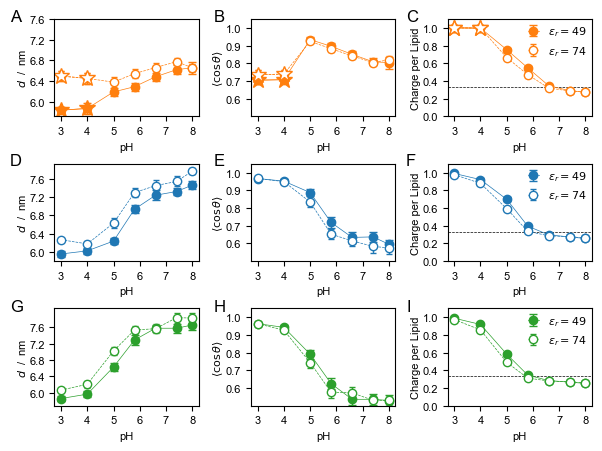

In [35]:
fig, axes = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(6,4.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
colors = ['tab:orange','tab:blue','tab:green']
for model,pKa,c,i in zip([1.86,2.54,3.09],[9.41,9.41,9.41],colors,range(3)):
    table = pd.read_pickle('{:.2f}_{:.2f}_rna.pkl'.format(model,pKa))
    table_74 = pd.read_pickle('{:.2f}_{:.2f}_rna_74.pkl'.format(model,pKa))
    for ax,o in zip(axes[i].flatten(),['d/nm','cos_theta','alpha']):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=1, capsize=3, capthick=1, color=c, ls='-',label=r'$\epsilon_r=49$')
        a_49 = table[o].AVG
        
        if table.loc[3.0,'cos_theta'].AVG<.95:
            ax.errorbar(table.index[:2],table[o].AVG.values[:2],table[o].SD.values[:2],lw=0.5, 
                marker='*',
                ms=12, elinewidth=1, capsize=2, capthick=1, 
                color=c, ls='-')
    
        ax.errorbar(table_74.index,table_74[o].AVG,table_74[o].SD,lw=0.5, marker='o', mfc='w', ms=6,
            elinewidth=1, capsize=2, capthick=1, color=c, ls='--',label=r'$\epsilon_r=74$')
        a_74 = table_74[o].AVG
        
        if table_74.loc[3.0,'cos_theta'].AVG<.95:
            ax.errorbar(table_74.index[:2],table_74[o].AVG.values[:2],table_74[o].SD.values[:2],lw=0.5, 
                marker='*', mfc='w',
                ms=12, elinewidth=1, capsize=2, capthick=1, 
                color=c, ls='--')
        
for i in range(3): 
    axes[i,0].set_ylabel(r'$d$  /  nm',labelpad=1)
    axes[i,0].set_yticks(np.arange(6,7.8,0.4))
    axes[i,1].set_ylabel(r'$\langle \cos{\theta} \rangle$',labelpad=1)
    axes[i,1].set_yticks(np.arange(.6,1.1,0.1))
    axes[i,1].set_ylim(.5,1.05)
    axes[i,2].set_ylabel(r'Charge per Lipid',labelpad=1)
    axes[i,2].set_yticks([0,.2,.4,.6,.8,1])
    axes[i,2].set_ylim(0,1.1)
    axes[i,2].axhline(1/3,ls='--',color='k',lw=.5,zorder=0)
    axes[i,2].legend(frameon=False,handlelength=1,loc='upper right',borderpad=0)

for ax in axes.flatten():
    ax.set_xlabel('pH')
    ax.set_xticks(range(3,9,1))

fig.text(0.01, .96, 'A', fontsize=12)
fig.text(0.35, .96, 'B', fontsize=12)
fig.text(0.67, .96, 'C', fontsize=12)
fig.text(0.01, .64, 'D', fontsize=12)
fig.text(0.35, .64, 'E', fontsize=12)
fig.text(0.67, .64, 'F', fontsize=12)
fig.text(0.01, .315, 'G', fontsize=12)
fig.text(0.35, .315, 'H', fontsize=12)
fig.text(0.67, .315, 'I', fontsize=12)
plt.tight_layout()
plt.savefig('figs/figS6.pdf',dpi=300)

### Fig. S7

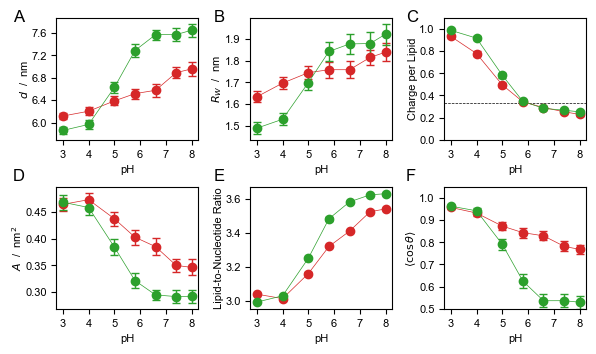

In [36]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(6,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
colors = ['tab:red','tab:green','tab:orange']
for model,pKa,c in zip([1.86,3.09],[8.46,9.41],colors):
    table = pd.read_pickle('{:.2f}_{:.2f}_rna.pkl'.format(model,pKa))
    for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','N/P','cos_theta']):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=1, capsize=3, capthick=1, color=c)
        if table.loc[3.0,'cos_theta'].AVG<.85:
            ax.errorbar(table.index[:2],table[o].AVG.values[:2],table[o].SD.values[:1],
                lw=0.5, marker='*', ms=12, 
                elinewidth=1, capsize=3, capthick=1, color=c)
        
axes.flatten()[0].set_ylabel(r'$d$  /  nm',labelpad=1)
axes.flatten()[1].set_ylabel(r'$R_W$  /  nm',labelpad=1)
axes.flatten()[2].set_ylabel(r'Charge per Lipid',labelpad=1)
axes.flatten()[3].set_ylabel(r'$A$  /  nm$^2$',labelpad=1)
axes.flatten()[4].set_ylabel(r'Lipid-to-Nucleotide Ratio',labelpad=1)
axes.flatten()[5].set_ylabel(r'$\langle \cos{\theta} \rangle$',labelpad=1)
for ax in axes.flatten():
    ax.set_xlabel('pH')
    ax.set_xticks(range(3,9,1))
axes.flatten()[0].set_yticks(np.arange(6,7.8,0.4))
axes.flatten()[1].set_yticks(np.arange(1.5,2.,0.1))
axes.flatten()[2].set_yticks([0,.2,.4,.6,.8,1])
axes.flatten()[5].set_yticks(np.arange(.5,1.05,0.1))
axes.flatten()[2].set_ylim(0,1.1)
axes.flatten()[5].set_ylim(.5,1.05)
axes.flatten()[2].axhline(1/3,ls='--',color='k',lw=.5,zorder=0)
fig.text(0.025, .955, 'A', fontsize=12)
fig.text(0.36, .955, 'B', fontsize=12)
fig.text(0.68, .955, 'C', fontsize=12)
fig.text(0.025, .5, 'D', fontsize=12)
fig.text(0.36, .5, 'E', fontsize=12)
fig.text(0.68, .5, 'F', fontsize=12)
plt.tight_layout()
plt.savefig('figs/figS7.pdf',dpi=300)

### Fig. S2

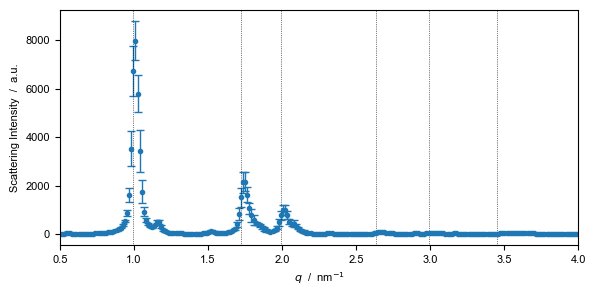

In [37]:
fig = plt.figure(figsize=(6,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

x,y,z = np.loadtxt('data/scattering_S2.csv',unpack=True,skiprows=1,delimiter=';',)

plt.errorbar(x,y,yerr=z,marker='o',ms=3,lw=0, 
            elinewidth=1,capsize=3,capthick=1,color='tab:blue')

plt.axvline(0.9965,color='k',ls=':',lw=.5)
plt.axvline(1.7261,color='k',ls=':',lw=.5)
plt.axvline(1.9931,color='k',ls=':',lw=.5)
plt.axvline(2.6366,color='k',ls=':',lw=.5)
plt.axvline(2.9896,color='k',ls=':',lw=.5)
plt.axvline(3.451977259,color='k',ls=':',lw=.5)

plt.xlim(0.5,4)

plt.ylabel('Scattering Intensity  /  a.u.')
plt.xlabel('$q$  /  nm$^{-1}$')

plt.tight_layout()
plt.savefig('figs/figS2.pdf',dpi=300)

### Fig. S3

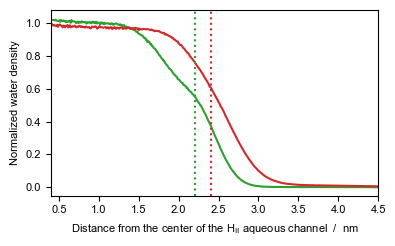

In [38]:
fig = plt.figure(figsize=(4,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

x,y = np.loadtxt('data/water_density_MC3_S3.csv',unpack=True,skiprows=1,delimiter=';',)
plt.plot(x,y,color='tab:green')
x,y = np.loadtxt('data/water_density_DD_S3.csv',unpack=True,skiprows=1,delimiter=';',)
plt.plot(x,y,color='tab:red')

plt.axvline(2.2,color='tab:green',ls=':')
plt.axvline(2.4,color='tab:red',ls=':')

plt.xlim(0.4,4.5)

plt.xlabel('Distance from the center of the H$_{\mathrm{II}}$ aqueous channel  /  nm')
plt.ylabel('Normalized water density')

plt.tight_layout()
plt.savefig('figs/figS3.pdf',dpi=300)

### Fig. S9

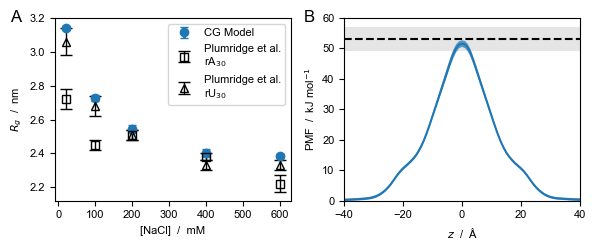

In [39]:
c = StringIO ("""-1.4661656804733727 0.7283026087431779
-1.3790650887573965 1.3083407975928765
-1.2892426035502957 2.688431660718038
-1.1994201183431952 4.458548202552464
-1.1095976331360946 6.9637131388774804
-1.019775147928994 9.813900790983766
-0.9299526627218935 13.099117084727325
-0.8442130177514793 16.54184374871886
-0.7666390532544378 19.99790462394833
-0.6972307692307691 23.534179113655938
-0.631905325443787 27.329428987250097
-0.5665798816568048 30.98029435478361
-0.5053372781065089 34.53981442256447
-0.4440946745562129 38.282025089850634
-0.3828520710059169 42.106741189171466
-0.32160946745562136 46.202546565177585
-0.24811834319526627 50.204060018858385
-0.16237869822485207 52.53671359729274
-0.0725562130177515 52.92673927600202
0.017266272189349063 53.061748164786
0.10708875739644963 52.56671557257807
0.20017751479289947 50.3195676237069
0.2704023668639053 46.98634816950681
0.3275621301775149 43.285390218237964
0.38063905325443814 39.67086652910068
0.43371597633136094 36.33136094674556
0.49087573964497055 32.818986840127366
0.5521183431952665 29.02079034396054
0.6174437869822489 25.287419544392364
0.6827692307692308 21.719059608893502
0.7521775147928995 18.14611603828162
0.829751479289941 14.528711207073272
0.9154911242603552 11.058982765324927
1.0053136094674557 7.5787536322267215
1.0951360946745563 4.803570918333762
1.1849585798816569 2.38841190786475
1.268656804733728 0.8245589461169516
""")
xE,yE = np.loadtxt(c,unpack=True)

fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

######## RNA ###########

rgs_mean = []
rgs_std = []
for cs in [20,100,200,400,600]:
    rg_replicas = []
    for i in range(3):
        rg = np.loadtxt(f'data/rna/replica_{i:d}/{cs:d}/Rg.dat',usecols=1)[2000:]
        rg_replicas.append(np.mean(rg)/10)
    rgs_mean.append(np.mean(rg_replicas))
    rgs_std.append(np.std(rg_replicas))
    
ax1.errorbar([20,100,200,400,600],rgs_mean,yerr=rgs_std,marker='o',ms=6,lw=0, 
            elinewidth=2,capsize=3,capthick=1,label='CG Model')
# DOI: 10.1021/jacs.9b04461
ax1.errorbar([20,100,200,400,600],[2.72,2.45,2.51,2.38,2.22],
         [.06,.03,.03,.02,.05],marker='s',elinewidth=1,capsize=4,capthick=1,
         lw=0,color='k',mfc='None',ms=6,label='Plumridge et al.\nrA$_{30}$')
ax1.errorbar([20,100,200,400,600],[3.06,2.68,2.51,2.33,2.33],
         [.08,.06,.03,.03,.03],marker='^',elinewidth=1,capsize=4,capthick=1,
         lw=0,color='k',mfc='None',ms=6,label='Plumridge et al.\nrU$_{30}$')
ax1.legend()
ax1.set_xlabel('[NaCl]  /  mM')
ax1.set_ylabel('$R_g$  /  nm')

######## lipid ###########

x = np.arange(-68,69,1)
pmf = []
for i in range(20):
    p = np.loadtxt(f'data/Na_bilayer/{i:d}/penalty.dat')*8.3145*320/1e3
    if np.abs(p.min()-p.max())>40:
        pmf.append(p-(p[-20:-2].mean()+p[2:20].mean())/2)
mean = -np.mean(pmf,axis=0)[2:-2]
mean = mean-mean[-1:].mean()
err = np.std(pmf,axis=0)[2:-2]
ax2.plot(x,mean)
ax2.fill_between(x,mean-err,mean+err,lw=0,alpha=.7)
ax2.set_ylim(0,60)
ax2.set_xlim(-40,40)
ax2.set_xlabel('$z$  /  Å')
ax2.set_ylabel('PMF  /  kJ mol$^{-1}$')
ax2.hlines(53,-40,40,color='k',ls='--')
ax2.axhspan(49,57,-40,40,lw=0, alpha=0.1,color='k',zorder=0)
np.savetxt('data/Na_bilayer/profile.dat',np.c_[x,mean,err])

fig.text(0.02, .92, 'A', fontsize=12)
fig.text(0.51, .92, 'B', fontsize=12)
plt.tight_layout()
plt.savefig('figs/figS9.pdf',dpi=300)

### Wrap and calculate $R_w$ for systems without RNA

In [ ]:
pH_values = [3.0]

vmd_path = 'csh /Applications/VMD_1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh'

Rcyls_298 = {}

for folder in ['lnp_empty_298']:  
    path = f'data/{folder:s}'+'/CPP{:.2f}_{:.2f}_{:.1f}'
    script_path = f'../snapshot.vmd'
    for pH in pH_values:
        for model,pKa,y_sel,out_sel in zip([1.86,3.09],[8.46,9.41],
                                         ['y<40','(y>40 and y<80)'],
                                         ['y>-25 and y<40','y>30 and y<85']):
            Rcyls_298[model] = []
            print('MODEL',model)
            for frame_number in range(1000,2001000,1000):
                current_path = path.format(model,pKa,pH)
                %cd {current_path}
                # Read in the file
                with open(script_path, 'r') as file :
                    filedata = file.read()
                filedata = filedata.replace('frame_number', f'{frame_number:d}')
                filedata = filedata.replace('y_sel', f'and {y_sel:s}')
                filedata = filedata.replace('out_sel', f'{out_sel:s}')
                with open('snapshot.vmd', 'w') as file:
                    file.write(filedata)
                !{vmd_path} -e snapshot.vmd -dispdev text > /dev/null 2>&1
                s = md.load(f'{frame_number:d}.pdb')
                s_hd = s.atom_slice(s.top.select('name HD or name HHD'))
                center = md.compute_center_of_geometry(s_hd)[0]
                Rcyls_298[model].append(np.sqrt((s_hd.xyz[0,:,0]-center[0])**2+(s_hd.xyz[0,:,1]-center[1])**2).mean()*10)
                %cd -

In [4]:
np.savetxt(f'data/lnp_empty_298/CPP1.86_8.46_3.0/Rcyl.dat',
           np.c_[np.arange(len(Rcyls_298[1.86]))*1000,Rcyls_298[1.86]])

In [5]:
np.savetxt(f'data/lnp_empty_298/CPP3.09_9.41_3.0/Rcyl.dat',
           np.c_[np.arange(len(Rcyls_298[3.09]))*1000,Rcyls_298[3.09]])